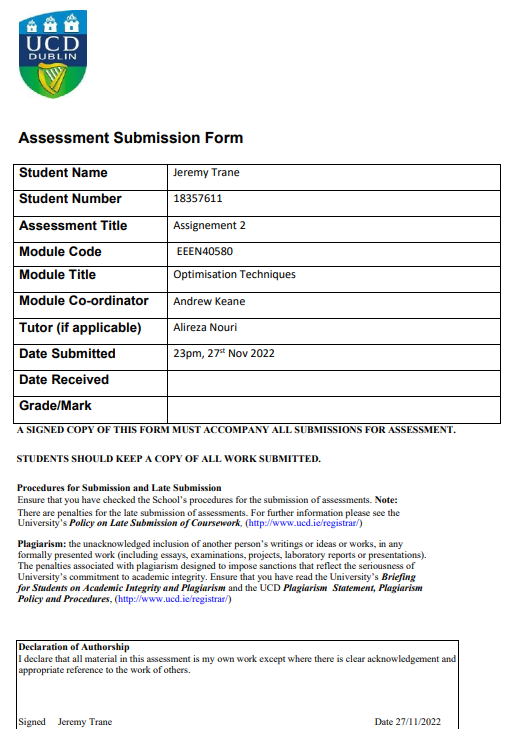

# Assignment 2 - Jeremy Trane

#### Student number 18357611, α = 1, β = 1.

I declare that all of the work provided in this report is in complience with the University policy on plagiarism.


## Question 1

I confirm I have read the first page of the report and understood it.

## Question 2

We are given a MILP problem, one where we have more tha one integer. The aim of this problem is to minimize the cost. There are two approaches to do this. 1. minimuze the groups or 2. minimuzing the cost. 

This can be done through the cost per extra group made:

$cost = 500 + 2(\alpha + \beta)+n$, where n is the number of students in the group and $\alpha$ is 1 and $\beta$ is 1.

From this, the objective function can be said to be the sum of all groups cost, and use a unit vaiable to denote if a group has any members or not.This gives us the objective function:

$2n(\alpha + \beta)+\sum\limits_{i=1}^{11}(500)U_i$

The constraints given in the assignment brief are as follows

- no members of each group have the same field of study

- no group member is in the same group as their close friends

When viewing the data 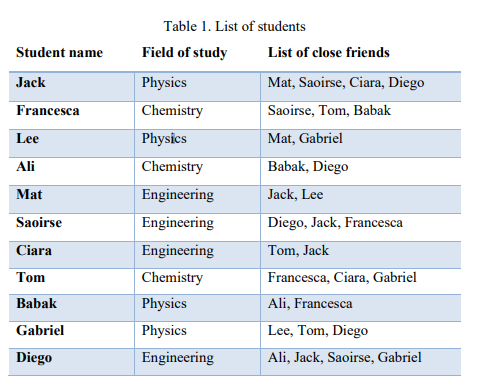

this is why the maximum number of groups as seen in the sum of the objective function is 11.
    
A unit variable will be used to determine if a student is currently in a group or not, as a student cannot be allocated two groups. 

The first constraint will only allow each of the students to be in one group. 

$\forall students \sum\limits_{groups=1}^{11}(U_{students,groups}) == 1$  
     
Next, we can find the constraint for whether there are students of the same field of study. This is formed, by comparing each student with one another and determining if they have the same field of study. This takes the following mathematical form.   
    
$\forall groups\ \forall studdents\ student\ \epsilon\ student1\ ⇔\ student\ \epsilon\ student2\ \forall subjects\ subject\ \epsilon\ field\ of\ student1\ ⇔\ subject\ \epsilon\  field\ of\ student2\ W(student1,group) + W(student2,group) <= 1$ 

Finally, we will set a constraint which will disallow close friends from being in the same group as one another.  In this case, we will iterate through each group and then iterate through each student and then iterate through each students close friends, then we can find is the W unit variable is true for the close friends and the student we are selecting a froup for.

$\forall groups\ \forall students\ \ W_{students,groups} + W_{close\ friends,groups} <= 1$ 
   
Therefore, our equations are;   
$\underbrace{\text{MIN}}_U \ 2n(\alpha + \beta)+\sum\limits_{i=1}^{11}(500)U_i$   
    
$\forall students \sum\limits_{groups=1}^{11}(U_{students,groups}) == 1$    
   
$\forall groups\ \forall students\ \ W_{students,groups} + W_{close\ friends,groups} <= 1$    
   
$\forall groups\ \forall studdents\ student\ \epsilon\ student1\ ⇔\ student\ \epsilon\ student2\ \forall subjects\ subject\ \epsilon\ field\ of\ student1\ ⇔\ subject\ \epsilon\  field\ of\ student2\ W(student1,group) + W(student2,group) <= 1$   
    


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pe
import pyomo.opt as po
import pandas as pd 

In [2]:
alpha=1
beta=1

In [3]:
#Reading in the csv file
df = pd.read_csv('list_of_students.csv')
student_index = list(df.loc[:,'Student name'])

We must now extract the data from our csv file. The code below allows us to obtain the field of study as well as the list of close friends for each student

In [4]:
#print(student_index)
field_of_study = {}
count = 0
for student in student_index:
    field_of_study[student] = df.loc[count, 'Field of study']
    count = count + 1
    
close_friends = {}
count = 0

for student in student_index:
    close_friends[student] = df.loc[count, 'List of close friends'].split(', ')
    count = count + 1

The next few steps as similar to all the previous solver problems done.

- We will create a mode

- We will initialize the model and set the parameters

- We will initialize the binary variables

- We will enstanciate the constraints

- And finally we will use a solver 

In [5]:
model = pe.ConcreteModel()

In [6]:
#Initialize model sets and parameters.
model.studentIndex = pe.Set(initialize = student_index)
model.closeFriends = pe.Param(model.studentIndex, initialize = close_friends)
model.fieldOfStudy = pe.Param(model.studentIndex, initialize = field_of_study)
model.groups = pe.RangeSet(1,11)

    'Any'. The default domain for Param objects is 'Any'.  However, we will be
    changing that default to 'Reals' in the future.  If you really intend the
    domain of this Paramto be 'Any', you can suppress this warning by
    explicitly specifying 'within=Any' to the Param constructor.  (deprecated
    in 5.6.9, will be removed in (or after) 6.0) (called from
    C:\Users\Jeremy\anaconda3\lib\site-
    packages\pyomo\core\base\indexed_component.py:645)
    'Any'. The default domain for Param objects is 'Any'.  However, we will be
    changing that default to 'Reals' in the future.  If you really intend the
    domain of this Paramto be 'Any', you can suppress this warning by
    explicitly specifying 'within=Any' to the Param constructor.  (deprecated
    in 5.6.9, will be removed in (or after) 6.0) (called from
    C:\Users\Jeremy\anaconda3\lib\site-
    packages\pyomo\core\base\indexed_component.py:645)


In [7]:
model.inGroup = pe.Var(model.studentIndex, model.groups, domain=pe.Binary)
model.groupsU = pe.Var(model.groups, domain=pe.Binary)

Each of the constraints described above can now be seen 

In [8]:
#One student per group constraint
model.studentOnce = pe.ConstraintList()
for student in model.studentIndex: #loop through each student
    expr = sum(model.inGroup[student,g] for g in model.groups) == 1 #Finds sum of binary variable
    model.studentOnce.add(expr)

#Different field of studies constraint
model.diffStudy = pe.ConstraintList()
for  g in model.groups: #Loops through groups
    for stud1 in model.studentIndex: #Loops through student
        for stud2 in model.studentIndex:#Loops through the other students
            if stud1 != stud2 and model.fieldOfStudy[stud1] == model.fieldOfStudy[stud2]: #Makes sure students don't match and checks their field of study.
                expr = (model.inGroup[stud1,g]+model.inGroup[stud2,g]) <= 1 #Adds binary variables if they arer in teh same group the expression fails.
                model.diffStudy.add(expr)
    
#Close friends in differnt groups constraint
model.blockedStudent = pe.ConstraintList()
for g in model.groups: #Loops through groups
    for student1 in model.studentIndex: #Loops through students
        for student2 in model.closeFriends[student1]: #Loops through students close friends
            expr = (model.inGroup[student1,g]+model.inGroup[student2,g])<=1 #Adds binary variables
            model.blockedStudent.add(expr)
            
#Fourth Constraint: 
model.HasStudent=pe.ConstraintList()
for g in model.groups:
    expr = sum(model.inGroup[student, g] for student in model.studentIndex) <= model.groupsU[g]*len(model.groups)
    model.HasStudent.add(expr)

In [9]:
#Objective function
def obj_rule(model): #Function finds the mode
    return sum((500)*model.groupsU[g] for g in model.groups)+2*(alpha+beta)*11#Find the sum of the binary variable and the cost
model.OF= pe.Objective(rule=obj_rule, sense=pe.minimize)

opt = pe.SolverFactory('gurobi')
results = opt.solve(model, tee = True)
if (results.solver.status == pe.SolverStatus.ok) and (results.solver.termination_condition == pe.TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == pe.TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  result.solver.status)

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\Jeremy\AppData\Local\Temp\tmp8023p9jq.pyomo.lp
Reading time = 0.00 seconds
x133: 683 rows, 133 columns, 1574 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i9-12900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 683 rows, 133 columns and 1574 nonzeros
Model fingerprint: 0x0a9bda47
Variable types: 1 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4044.0000000
Presolve removed 562 rows and 1 columns
Presolve time: 0.00s
Presolved: 121 rows, 132 columns, 550 nonzeros
Variable types: 0 continuous, 132 integer (132 binary)

Root relaxation: objective 2.544

In [10]:
output = pd.DataFrame(index=model.groups, columns=model.studentIndex)
for group in model.groups:
    for student in  model.studentIndex:
        if pe.value(model.inGroup[student,group]) == 1:
            print("The Student "+student+" is in group "+str(group))


The Student Francesca is in group 1
The Student Lee is in group 1
The Student Diego is in group 1
The Student Ali is in group 7
The Student Saoirse is in group 7
The Student Gabriel is in group 7
The Student Ciara is in group 9
The Student Mat is in group 10
The Student Tom is in group 10
The Student Babak is in group 10
The Student Jack is in group 11


In [11]:
print(pe.value(model.OF))

2544.0


## Question 3

Find the optimal value of the following functions using the requested methods (35 Points)


F($x_{1}, x_{2}) = (α+1)(x_{1} - 1)^2 + (β+2)(x_{2} - 2)^2 + (α+β+2) x_{1}*x_{2}$ + 5α  
G($x_{1}, x_{2}) = 0.05(x_{1} - 1)^4 - (x_{1} - 1)^2 + 2(x_{1} - 1) + 0.1(α+β+10) (x2 - 2)^2$

### A) Using Steepest descent method, with a stepsize of 0.05. (9 points)  

The theory behind this code follows that of the one found in the lectures notes, this being  

- An initial starting value was obtained (in this case as can be seen with the nested for loop, we will iterate between each value of x1 and x2 in the range [-10, -5, 0, 5, 10]).  

- We will calculate the gradient of our f function found above with respect to both $x_{1}$ and $x_{2}$  

- We will multiply this by our step size, in this case 0.05 and move in the direction opposite of it  

- We will update our x value to reach a closer value to the optimum value given the step size and starting point   

- We will plot the results

For function F this gives:


For the start values of X1=  -10  and X2=  -10  the final values of X1 and X2 respectively are  -15.017147975820079 2.979449405278527  and  f=  503.0788889289213
For the start values of X1=  -10  and X2=  -5  the final values of X1 and X2 respectively are  -16.7447840747625 3.097126603544421  and  f=  617.6214975810828
For the start values of X1=  -10  and X2=  0  the final values of X1 and X2 respectively are  -18.472420173704922 3.2148038018103158  and  f=  744.0234570320737
For the start values of X1=  -10  and X2=  5  the final values of X1 and X2 respectively are  -20.20005627264734 3.33248100007621  and  f=  882.284767281893
For the start values of X1=  -10  and X2=  10  the final values of X1 and X2 respectively are  -21.927692371589767 3.4501581983421046  and  f=  1032.405428330542
For the start values of X1=  -5  and X2=  -10  the final values of X1 and X2 respectively are  -12.480780239034797 2.8066857953842854  and  f=  356.40324617884175
For the start values of X1=  -5  and

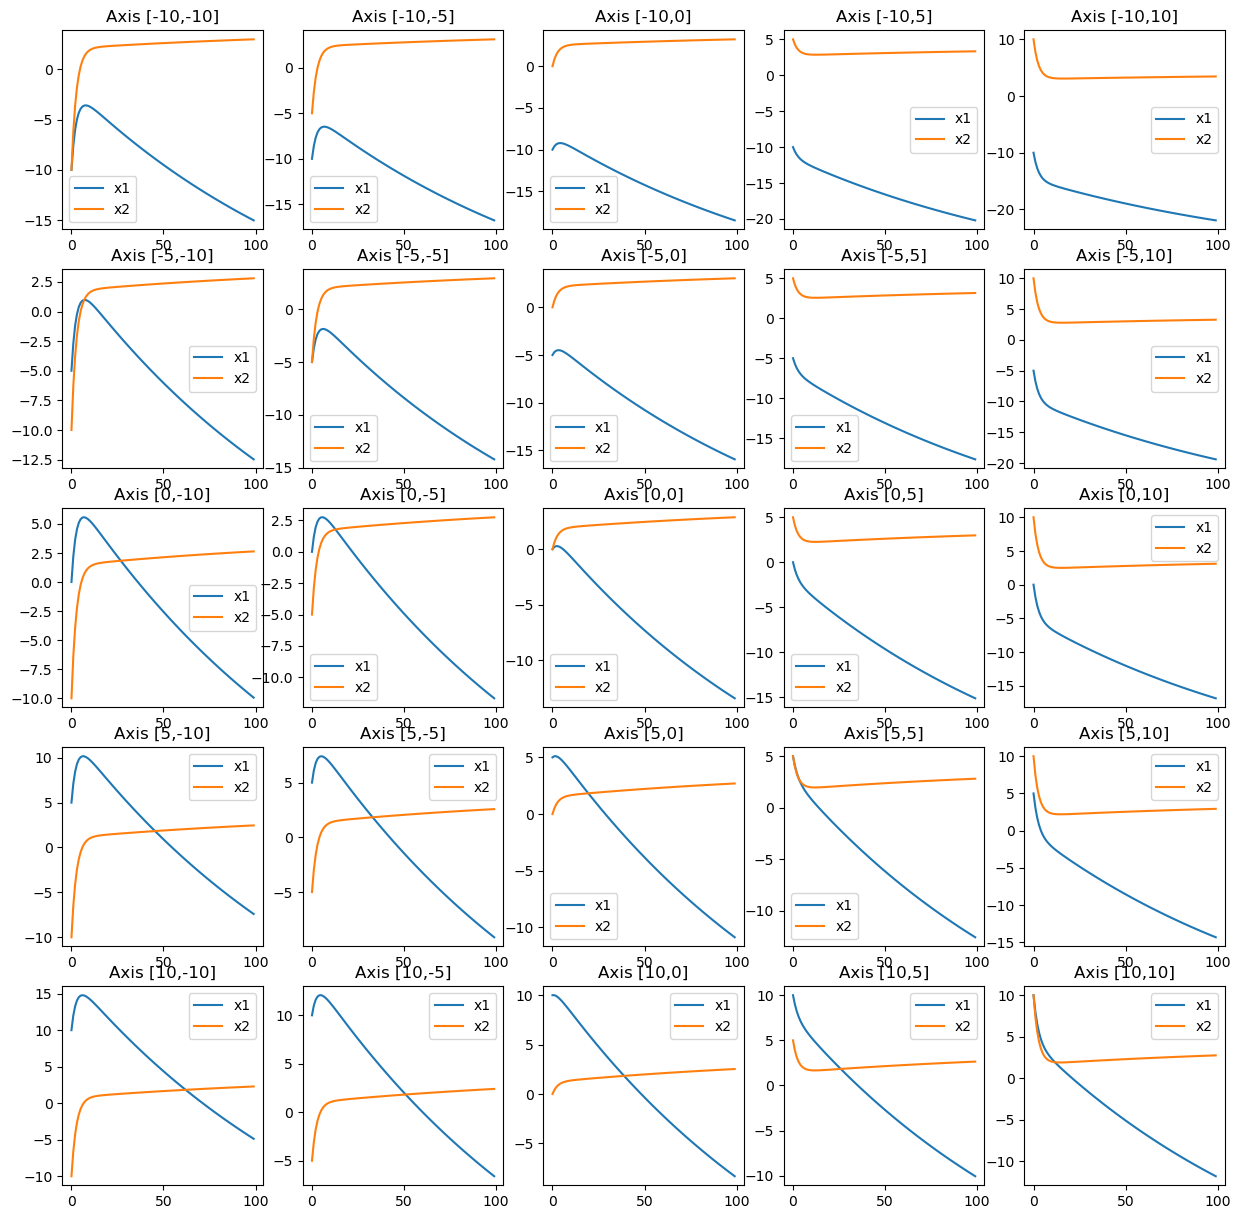

In [12]:
#Importing packages
import numpy as np
import matplotlib.pyplot as plt

#Plotting subplots for later
fig, axs = plt.subplots(5,5,figsize=(15,15))

#Declaring array of initial start values
x1_values = [-10, -5, 0, 5, 10]
x2_values = [-10, -5, 0, 5, 10]

#Declaring constants
N = 100
alpha=1
beta=1
step = 0.05

#Double for loop to iterate through each start value
for i, x1_start_value in enumerate(x1_values):
    for j, x2_start_value in enumerate(x2_values):
        
        #Declaring empty vector
        X1=[]
        X2=[]
        F=[]
        
        #Updating start value
        x1=x1_start_value
        x2=x2_start_value
        
        #For loop to iterate through values while updating x1 and x2
        for n in range(0,N):
            X1.append(x1)
            X2.append(x2)
            F.append((alpha+1)*(x1 - 1)**2 + (beta+2)*(x2-2)**2+0.1*(alpha+beta+2)*x1*x2 + 5*alpha)
            d1=-(0.4*x1+4*x2-4)
            d2=-(0.4*x1+6*x2-12)
            x1=x1+d1*step
            x2=x2+d2*step
            
        #Plotting the results
        axs[i,j].plot(range(0,N), X1, label='x1')
        axs[i,j].plot(range(0,N), X2, label='x2')
        #axs[i,j].plot(range(0,N), F, label='f')
        axs[i,j].set_title('Axis ['+str(x1_start_value)+','+str(x2_start_value)+']')
        axs[i,j].legend()
        print("For the start values of X1= ", x1_start_value, " and X2= ", x2_start_value, " the final values of X1 and X2 respectively are ", X1[-1], X2[-1], " and  f= ",F[-1])

For a graph to be converging we mustsee both lines settle to a constant or plateau off.   
As we can see from our results above, it is clear that none of the x1 values settle to a constant as they still have a rather large slope. For this reason we can come to the conclusion that these do not converge. (The other option being that we have not ran enough iteration, however, for computational cost I could not run more than 100).

### For function G this gives:

The same process is applied as shown above except to function G, which can be found at the start of the assignment

For the start values of X1=  -10  and X2=  -10  the final values of X1 and X2 respectively are  -2.577067089967265 1.9999617205412108  and  g=  -11.763418613781022
For the start values of X1=  -10  and X2=  -5  the final values of X1 and X2 respectively are  -2.577067089967265 1.9999776703157062  and  g=  -11.763418614941065
For the start values of X1=  -10  and X2=  0  the final values of X1 and X2 respectively are  -2.577067089967265 1.9999936200902018  and  g=  -11.763418615490558
For the start values of X1=  -10  and X2=  5  the final values of X1 and X2 respectively are  -2.577067089967265 2.000009569864697  and  g=  -11.763418615429503
For the start values of X1=  -10  and X2=  10  the final values of X1 and X2 respectively are  -2.577067089967265 2.000025519639193  and  g=  -11.7634186147579
For the start values of X1=  -5  and X2=  -10  the final values of X1 and X2 respectively are  -2.5770894451364654 1.9999617205412108  and  g=  -11.763418615199651
For the start values of X1

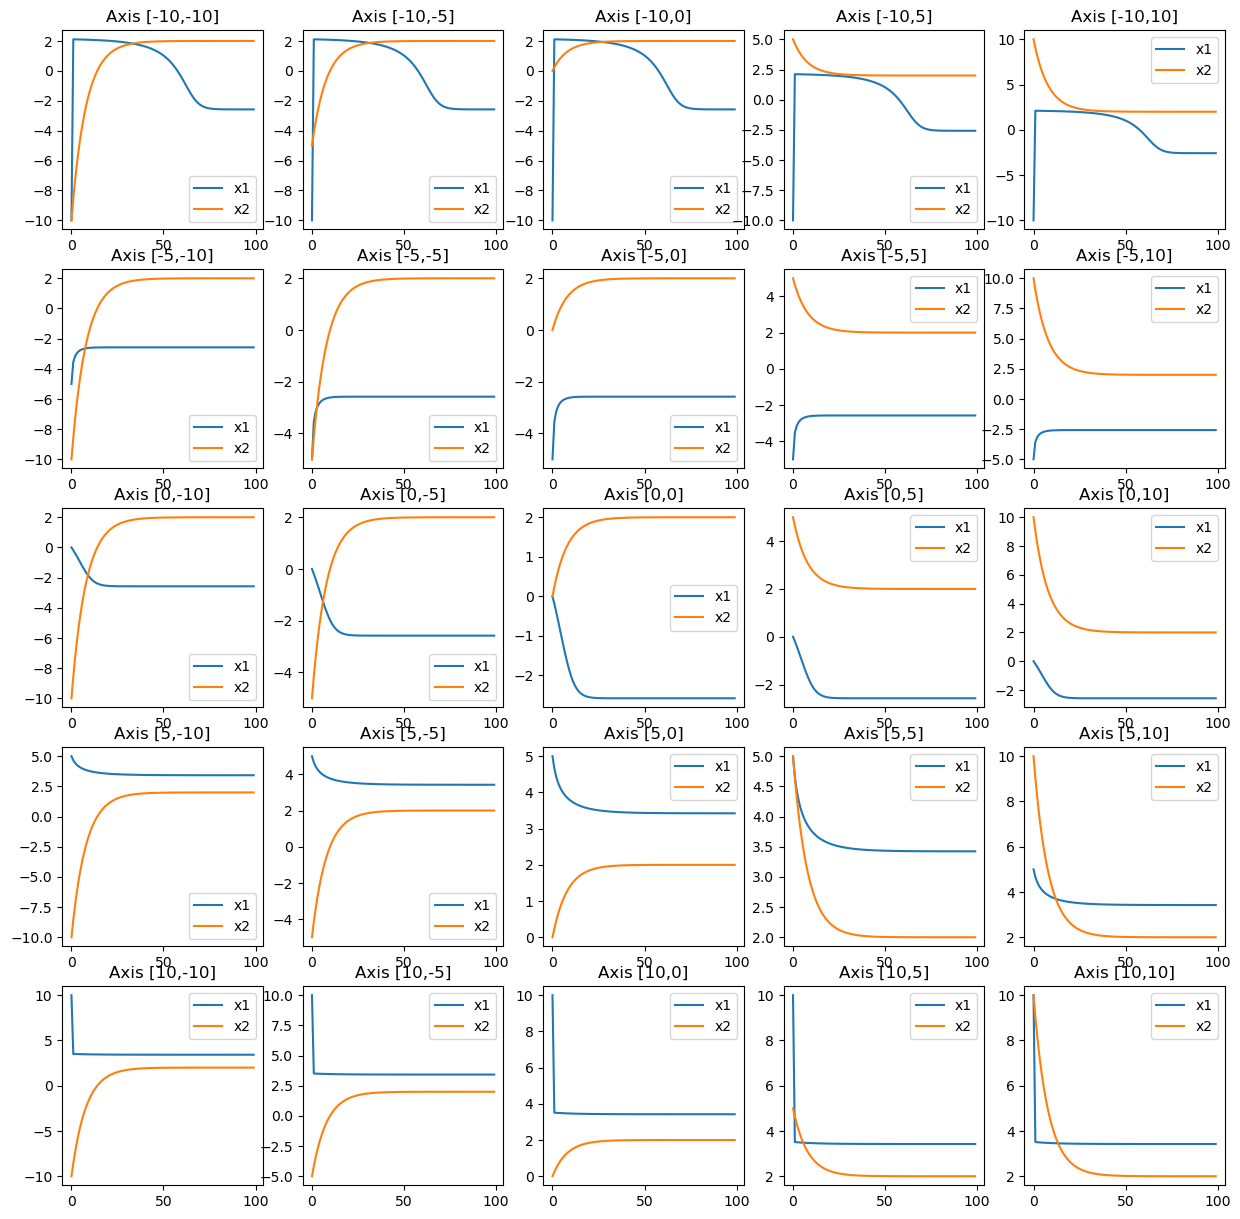

In [13]:
#Importing packages
import numpy as np
import matplotlib.pyplot as plt

#Plotting subplots for later
fig, axs = plt.subplots(5,5,figsize=(15,15))

#Declaring array of initial start values
x1_values = [-10, -5, 0, 5, 10]
x2_values = [-10, -5, 0, 5, 10]

#Declaring constants
N = 100
alpha=1
beta=1
step = 0.05

#Double for loop to iterate through each start value
for i, x1_start_value in enumerate(x1_values):
    for j, x2_start_value in enumerate(x2_values):
        
        #Declaring empty vector
        X1=[]
        X2=[]
        G=[]
        
        #Updating start value
        x1=x1_start_value
        x2=x2_start_value
        
        #For loop to iterate through values while updating x1 and x2
        for n in range(0,N):
            X1.append(x1)
            X2.append(x2)
            G.append(0.05*(x1-1)**4-(x1-1)**2+2*(x1-1)+0.1*(alpha+beta+10)*(x2-2)**2)
            d1=-(-2*(x1-1)+2+(((x1-1)**3)/5))
            d2=-(12*x2/5-24/5)
            x1=x1+d1*step
            x2=x2+d2*step
            
        #Plotting the results
        axs[i,j].plot(range(0,N), X1, label='x1')
        axs[i,j].plot(range(0,N), X2, label='x2')
        #axs[i,j].plot(range(0,N), G, label='g')
        axs[i,j].set_title('Axis ['+str(x1_start_value)+','+str(x2_start_value)+']')
        axs[i,j].legend()
        print("For the start values of X1= ", x1_start_value, " and X2= ", x2_start_value, " the final values of X1 and X2 respectively are ", X1[-1], X2[-1], " and  g= ",G[-1])

We can see a much different result compared to the one found for our F function. In contrast to the graphs found for the F function, all of these graphs plateau off or settle to a constant. For this reason we can assume that these do converge.   

Another method for this would be to set a threshold value ε, and if our change is under this value we could break and note this as converging, however, I prefered this approach as it lets us see every itteration of the code even if the graph was to converge early on.  

As we can see from the graph above, when our starting value for x1 is between -10 and 0, our $X_{1}$ value seems to settle at approximately 2.5, and our $X_{2}$ value at 2. 

When our $x_{1}$ value is between 5 and 10 our $X_{1}$ value settles at a higher 4, and $X_{2}$ at 2.

### B) Using Steepest descent method, with the optimal stepsize. (15 points)

For the code below, the same method as above is used except the stepsize is calculated.  
This is done using the same approach as explained in the notes once again.  
The method used to calculate the optimum step size is outlined below:  

- Once the gradient is calculated, a single variable objective function, i.e.,f(α),by replacing X with X -α∇f  (${X}^k$) in f(${X}^k$).

- The single variable optimization is solved using the diff and solve functions.

- From this ${X}^{k+1}$ = ${X}^k$ - ${α}^{opt}$∇f(${X}^k$) was found.

- As below, a set number of iterations was used and not a threshold however, a threshold could easily have been implemented with an if and break statement.


For the start values of X1=  -10  and X2=  -10  the final values of X1 and X2 respectively are  -1.22484052348917 3.48538330279906  and  f=  19.8113058949575
For the start values of X1=  -10  and X2=  -5  the final values of X1 and X2 respectively are  -3.81900006657237 4.83360480502082  and  f=  68.1496570274965
For the start values of X1=  -10  and X2=  0  the final values of X1 and X2 respectively are  -6.54467898203318 6.16186881005988  and  f=  154.676836543816
For the start values of X1=  -10  and X2=  5  the final values of X1 and X2 respectively are  -8.27230214236913 6.98463079253118  and  f=  228.379215944831
For the start values of X1=  -10  and X2=  10  the final values of X1 and X2 respectively are  -11.1932217724021 8.35786193462604  and  f=  386.195978650306
For the start values of X1=  -5  and X2=  -10  the final values of X1 and X2 respectively are  0.792477078989313 2.00524686632861  and  f=  5.72185898602065
For the start values of X1=  -5  and X2=  -5  the final val

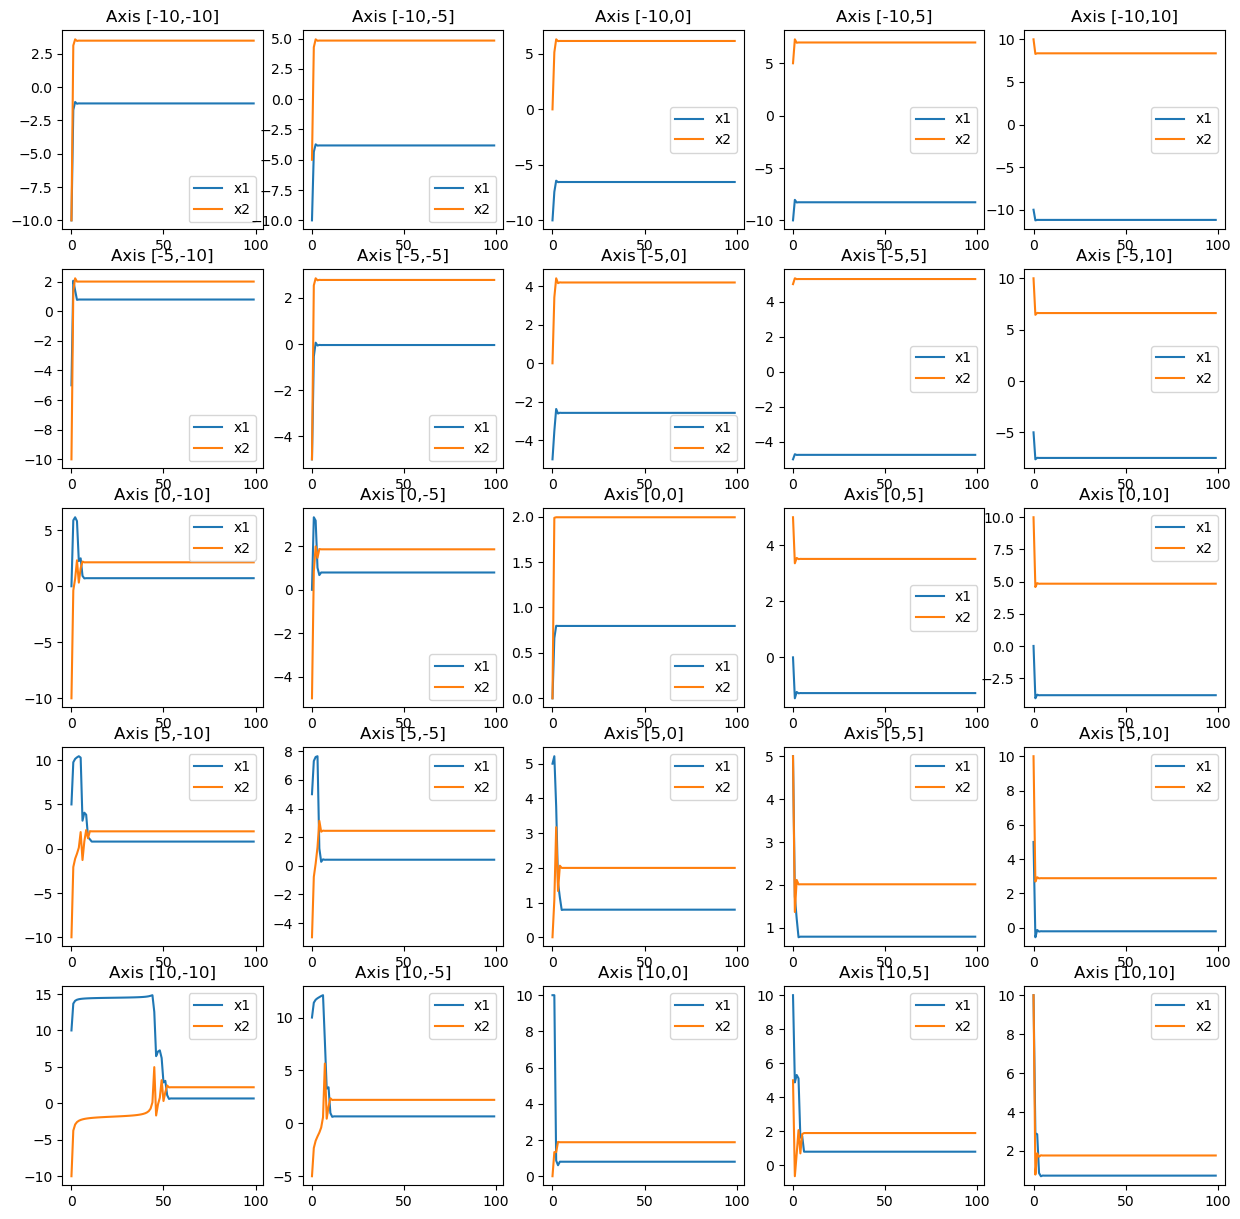

In [14]:
#Importing packages
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

#Plotting subplots for later
fig, axs = plt.subplots(5,5,figsize=(15,15))

#Declaring array of initial start values
x1_values = [-10, -5, 0, 5, 10]
x2_values = [-10, -5, 0, 5, 10]

#Declaring constants
N = 100
alpha=1
beta=1
A = Symbol('A')

#Double for loop to iterate through each start value
for i, x1_start_value in enumerate(x1_values):
    for j, x2_start_value in enumerate(x2_values):
        
        #Declaring empty vector
        X1=[]
        X2=[]
        F=[]
        
        #Updating start value
        x1=x1_start_value
        x2=x2_start_value
        
        #For loop to iterate through values while updating x1 and x2
        for n in range(0,N):
            X1.append(x1)
            X2.append(x2)
            F.append((alpha+1)*(x1 - 1)**2 + (beta+2)*(x2-2)**2+0.1*(alpha+beta+2)*x1*x2 + 5*alpha)
            d1=-(0.4*x1+4*x2-4)
            d2=-(0.4*x1+6*x2-12)
            new_x1=x1-d1*A
            new_x2=x2-d2*A
            eq_with_alpha=(alpha+1)*(new_x1 - 1)**2 + (beta+2)*(new_x2-2)**2+0.1*(alpha+beta+2)*new_x1*new_x2 + 5*alpha
            diff_eq_with_alpha=eq_with_alpha.diff(A)
            alpha_value_calculated=solve(diff_eq_with_alpha)
            x1=x1-d1*alpha_value_calculated[0]
            x2=x2-d2*alpha_value_calculated[0]
            
        #Plotting the results
        axs[i,j].plot(range(0,N), X1, label='x1')
        axs[i,j].plot(range(0,N), X2, label='x2')
        #axs[i,j].plot(range(0,N), F, label='f')
        axs[i,j].set_title('Axis ['+str(x1_start_value)+','+str(x2_start_value)+']')
        axs[i,j].legend()
        print("For the start values of X1= ", x1_start_value, " and X2= ", x2_start_value, " the final values of X1 and X2 respectively are ", X1[-1], X2[-1], " and  f= ",F[-1])

We can see a much different result thant the ones originally found for the F function with a set stepsize. Contrary to before, all fo these values do settle with $X_{1}$ setting at around 1 for most of the start values and $x_{2}$ settling at 2 to 2.5.

### The same process is repeated for the G function this time.

In [ ]:
#Importing packages
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

#Plotting subplots for later
fig, axs = plt.subplots(5,5,figsize=(15,15))

#Declaring array of initial start values
x1_start = [-10, -5, 0, 5, 10]
x2_start = [-10, -5, 0, 5, 10]

#Declaring constants
N = 50
alpha=1
beta=1
A = Symbol('A')

#Double for loop to iterate through each start value
for i, x1_start_value in enumerate(x1_start):
    for j, x2_start_value in enumerate(x2_start):
        
        #Declaring empty vector
        X1=[]
        X2=[]
        G=[]
        
        #Updating start value
        x1=x1_start_value
        x2=x2_start_value
        
        #For loop to iterate through values while updating x1 and x2
        for n in range(0,N):
            X1.append(x1)
            X2.append(x2)
            G.append(0.05*(x1-1)**4-(x1-1)**2+2*(x1-1)+0.1*(alpha+beta+10)*(x2-2)**2)
            d1=-(-2*(x1-1)+2+(((x1-1)**3)/5))
            d2=-(12*x2/5-24/5)
            new_x1=x1-d1*A
            new_x2=x2-d2*A
            eq_with_alpha=(0.05*(new_x1-1)**4-(new_x1-1)**2+2*(new_x1-1)+0.1*(alpha+beta+10)*(new_x2-2)**2)
            diff_eq_with_alpha=eq_with_alpha.diff(A)
            alpha_value_calculated=solve(diff_eq_with_alpha)
            x1=x1-d1*alpha_value_calculated[0]
            x2=x2-d2*alpha_value_calculated[0]
            
        #Plotting the results
        axs[i,j].plot(range(0,N), X1, label='x1')
        axs[i,j].plot(range(0,N), X2, label='x2')
        #axs[i,j].plot(range(0,N), G, label='g')
        axs[i,j].set_title('Axis ['+str(x1_start_value)+','+str(x2_start_value)+']')
        axs[i,j].legend()
        print("For the start values of X1= ", x1_start_value, " and X2= ", x2_start_value, " the final values of X1 and X2 respectively are ", X1[-1], X2[-1], " and  g= ",G[-1])

As expected, we can see that once again for our G(${x}_1$, ${x}_2$), all of our graphs converge. This is. expected as, as it converged with a set step size, it was expected that with an optimal stepsize it would also converge.

The main difference which can be seen is that the convergence is obtained after a much smaller number of iterations. Below, the convergence was reached after 40-50 iteration whereas, as we can see from the graphs above, the convergence is met after 5-10 iterations. A much shorter number of iterations.

Note: My kernal seems to freeze when running this code however, when restarting the kernel and wiping the output I am able to achieve a result.

### C) Using Newton’s method. (20 points)

For section C we will use Newton's method to calculate the optimal value

The methodology behind this code follows a similar one found to the one in the lecture notes. These are:

- We are given the function F stated at the top of the report.

- From this the derivative is calculated 

- From the result of the derivative we are able to obtain the Hessian Matrix

- Once the Hessian Matrix is obtained, the inverse matrix is then obtained

- Finally, similarly to in question 3 B) our X value is updated

In [ ]:
from sympy import symbols, Matrix, simplify, hessian
import re
import matplotlib.pyplot as plt

#Plotting subplots for later
fig,axs = plt.subplots(5,5,figsize=(15,15))

#Declaring array of initial start values
x1_values = [-10, -5, 0, 5, 10]
x2_values = [-10, -5, 0, 5, 10]

#Declaring constants
alpha = 1
beta = 1
x_1 = symbols('x_1')
x_2 = symbols('x_2')
N = 100

F = (alpha+1)*(x_1 - 1)**2 + (beta+2)*(x_2-2)**2+0.1*(alpha+beta+2)*x_1*x_2+5*alpha

#Setting up Hessian Matrix
X = Matrix([x_1,x_2])
f = Matrix([F])
gradf = simplify(f.jacobian(X))
coefficients_x1 = re.findall(r'[\d\.]+', str(gradf[0]))
coefficients_x2 = re.findall(r'[\d\.]+', str(gradf[1]))
# Obtain the hessian Matrix
hessianf = simplify(hessian(f,X))
# Obtain the Inverse Hessian Matrix
invhessianf = hessianf.inv()

#Double for loop to iterate through each start value
for i,x1_start_value in enumerate(x1_values):
        for j,x2_start_value in enumerate(x2_values):
            #Declaring empty vector
            X1 = [] 
            X2 = [] 
            F = [] 
            x1 = x1_start_value
            x2 = x2_start_value

            for k in range(0,N):
                X1.append(x1)
                X2.append(x2)
                F.append((alpha+1)*(x1-1)**2 + (beta+2)*(x2-2)**2+0.1*(alpha+beta+2)*x1*x2+(5*alpha))
                d1 = -((float(coefficients_x1[0])*(x1-1)) + float(coefficients_x1[2])*x2)
                d2 = -((float(coefficients_x2[2])*(x2-2) + float(coefficients_x2[0])*x1))
                x1 = -((invhessianf[0]*d1)*(invhessianf[1]*d2)) + x1
                x2 = -((invhessianf[2]*d1)*(invhessianf[3]*d2)) + x2

            # Plot the subplots 
            axs[i,j].plot(range(0,N), X1, label='x1')
            axs[i,j].plot(range(0,N), X2, label='x2')
            axs[i,j].set_title('Axis ['+str(x1_start_value)+','+str(x2_start_value)+']')
            axs[i,j].legend()
            print("For the start values of X1= ", x1_start_value, " and X2= ", x2_start_value, " the final values of X1 and X2 respectively are ", X1[-1], X2[-1], " and  f= ",F[-1],"\n")

### For function G this gives:

The same process is applied as shown above except to function G, which can be found at the start of the assignment

In [ ]:
from sympy import symbols, Matrix, simplify, hessian
import re
import matplotlib.pyplot as plt
import numpy as np

#Plotting subplots for later
fig,axs = plt.subplots(5,5,figsize=(15,15))

#Declaring array of initial start values
x1_values = [-10, -5, 0, 5, 10]
x2_values = [-10, -5, 0, 5, 10]

#Declaring constants
alpha = 1
beta = 1
x_1 = symbols('x_1')
x_2 = symbols('x_2')
N = 100

G = 0.05*(x_1-1)**4 - (x_1-1)**2 + 2*(x_1-1) + 0.1*(alpha+beta+10)*(x_2-2)**2

# Declare the General Matrices
X = Matrix([x_1,x_2])
g = Matrix([G])
gradf = simplify(g.jacobian(X))
coefficients_x1 = re.findall(r'[\d\.]+', str(gradf[0]))
coefficients_x2 = re.findall(r'[\d\.]+', str(gradf[1]))
# Obtain the hessian Matrix
hessianf = simplify(hessian(g,X))
# Obtain the Inverse Hessian Matrix
invhessianf = hessianf.inv()

coefficients_h1 = re.findall(r'[\d\.]+', str(invhessianf[0]))

# Using the nested for-loop to iterate throigh the x1 and x2 values
for i,x1_start_value in enumerate(x1_values):
    for j,x2_start_value in enumerate(x2_values):
        
        X1 = [] 
        X2 = [] 
        G = [] 
        x1 = x1_start_value
        x2 = x2_start_value
        
        # Using another nested-for-loop to execute the set number of iterations 
        for k in range(0,N):
            X1.append(x1)
            X2.append(x2)
            G.append(0.05*(x1-1)**4 - (x1-1)**2 + 2*(x1-1) + 0.1*(alpha+beta+10)*(x2-2)**2)
            d1 = (-float(coefficients_x1[0])*x1 + float(coefficients_x1[2])*(x1-1)**3 + float(coefficients_x1[6]))
            d2 = (float(coefficients_x2[0])*x2 - float(coefficients_x2[2]))
            gradients_updated = np.array([d1 , d2])
            # Get the value of the Hessian Matrix entry 0 as it is not a constant value after second-derivative
            inv_hessian_0 = (float(coefficients_h1[0]))/(float(coefficients_h1[1])*x1**2-float(coefficients_h1[4])*x1 - float(coefficients_h1[6]))
            Inverse_Hessian_Updated = np.array([[inv_hessian_0,invhessianf[1]] , [invhessianf[2],invhessianf[3]]])
            # Obtain the updated value of x1 and x2 based on the previous values
            [x1,x2] = -np.matmul(Inverse_Hessian_Updated,gradients_updated) + np.array([x1,x2])
        # Plot the subplots
        axs[i,j].plot(range(0,N), X1, label='x1')
        axs[i,j].plot(range(0,N), X2, label='x2')
        axs[i,j].set_title('Axis ['+str(x1_start_value)+','+str(x2_start_value)+']')
        axs[i,j].legend()
        print("For the start values of X1= ", x1_start_value, " and X2= ", x2_start_value, " the final values of X1 and X2 respectively are ", X1[-1], X2[-1], " and  g= ",G[-1], "\n")

## Question 4
### Decision-making with uncertain future

This problem is a MILP. This is where we have more than one integer in the problem. In this problem we have to solve an optimal production plan. In this problem we have to solve a minimization problem as we wish to minimize costs. This is done through the following objective function:

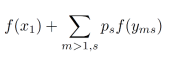

Where, ${x}_1$ is the production in the first month, ${y}_ms$ is the production in month m > 1 and scenario s, and ${p}_s$ is the probability of scenario s.

For this problem, we will create a model which will take in all of the variables provided to us in the table below:

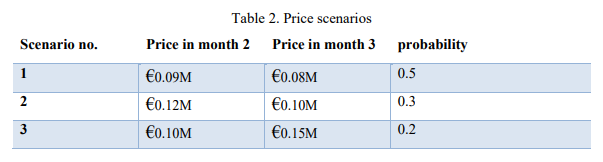

- probability
- Price in month 2
- Price in month 3

Once these have been created we will apply each model to our function 0.002*(α+β+20)${x}^2$+0.15x+0.2  €M

Next we need to formulate the constaints. We must satisfty that the maximum production capacity is 5 tonnes per month and that the production of 10 tonnes of this substance should be done in 3 months.  
This can be seen in the code below. The second constaint is done using the data available from the image above.

Finally, a nonlinear solver is used to solve the problem, in this case gurobi, which must be installed.

Importing the packages

In [ ]:
import pyomo.environ as pe
import pyomo.opt as po

Creating a model

In [ ]:
model = pe.ConcreteModel()

Adding variables to the model

In [ ]:
model.x1 = pe.Var(domain = pe.PositiveReals)
model.y21 = pe.Var(domain = pe.PositiveReals)
model.y31 = pe.Var(domain = pe.PositiveReals)
model.y22 = pe.Var(domain = pe.PositiveReals)
model.y32 = pe.Var(domain = pe.PositiveReals)
model.y23 = pe.Var(domain = pe.PositiveReals)
model.y33 = pe.Var(domain = pe.PositiveReals)

Setting up variables

In [ ]:
#Setting up probabilities
prob_1 = 0.5
prob_2 = 0.3
prob_3 = 0.2

#Months/scenario
first_month = 0.10
month_2_senario_1 = 0.09
month_3_senario_1 = 0.08
month_2_senario_2 = 0.12
month_3_senario_2 = 0.10
month_2_senario_3 = 0.10
month_3_senario_3 = 0.15

alpha = 1
beta = 1

cost_1 = 0.002*alpha*beta*(model.x1**2) + 0.15*model.x1 + 0.02
cost_21 = 0.002*alpha*beta*(model.y21**2) + 0.15*model.y21 + 0.02
cost_31 = 0.002*alpha*beta*(model.y31**2) + 0.15*model.y31 + 0.02
cost_22 = 0.002*alpha*beta*model.y22**2 + 0.15*model.y22 + 0.02
cost_32 = 0.002*alpha*beta*model.y32**2 + 0.15*model.y32 + 0.02
cost_23 = 0.002*alpha*beta*model.y23**2 + 0.15*model.y23 + 0.02
cost_33 = 0.002*alpha*beta*model.y33**2 + 0.15*model.y33 + 0.02

In [ ]:
Fx_1 = model.x1*first_month + cost_1
Fy_21 = model.y21*month_2_senario_1 + cost_21
Fy_31 = model.y31*month_3_senario_1 + cost_31
Fy_22 = model.y22*month_2_senario_2 + cost_22
Fy_32 = model.y32*month_3_senario_2 + cost_32
Fy_23 = model.y23*month_2_senario_3 + cost_23
Fy_33 = model.y33*month_3_senario_3 + cost_33

We will then setup all the constraints as given in the assignment brief, these being that 
- The maximum production capacity is 5 tonnes per month
- The production of 10 tonnes of this substance should be done in 3 months.


In [ ]:
lhs = model.x1
rhs = 5
model.x1_max_prod_cons = pe.Constraint(expr = lhs <= rhs)

lhs = model.y21
rhs = 5
model.y21_max_prod_cons = pe.Constraint(expr = lhs <= rhs)

lhs = model.y31
rhs = 5
model.y31_max_prod_cons = pe.Constraint(expr = lhs <= rhs)

lhs = model.y22
rhs = 5
model.y22_max_prod_cons = pe.Constraint(expr = lhs <= rhs)

lhs = model.y32
rhs = 5
model.y32_max_prod_cons = pe.Constraint(expr = lhs <= rhs)

lhs = model.y23
rhs = 5
model.y23_max_prod_cons = pe.Constraint(expr = lhs <= rhs)

lhs = model.y33
rhs = 5
model.y33_max_prod_cons = pe.Constraint(expr = lhs <= rhs)

lhs = model.x1 + prob_1*(model.y21 + model.y31) + prob_2*(model.y22 + model.y32) + prob_3*(model.y23 + model.y33)
rhs = 10
model.total_prod_cons = pe.Constraint(expr = lhs >= rhs)

lhs = model.x1 + model.y21 + model.y31
rhs = 10
model.s1_prod_cons = pe.Constraint(expr = lhs >= rhs)

lhs = model.x1 + model.y22 + model.y32
rhs = 10
model.s2_prod_cons = pe.Constraint(expr = lhs >= rhs)

lhs = model.x1 + model.y23 + model.y33
rhs = 10
model.s3_prod_cons = pe.Constraint(expr = lhs >= rhs)

In [ ]:
expr = Fx_1 + prob_1*(Fy_21 + Fy_31) + prob_2*(Fy_22 + Fy_32) + prob_3*(Fy_23 + Fy_33)
model.obj = pe.Objective(sense = pe.minimize, expr = expr)

Using gurobi solver, we can analyse this

In [ ]:
solver = po.SolverFactory('gurobi')
#solver = po.SolverFactory('glpk')

solver.solve(model, tee=True)

Printing out results

In [ ]:
solution_dict = {'x1': pe.value(model.x1),
                'y21': pe.value(model.y21),
                'y31': pe.value(model.y31),
                'y22': pe.value(model.y22),
                'y32': pe.value(model.y32),
                'y23': pe.value(model.y23),
                'y33': pe.value(model.y33),
                'cost': pe.value(model.obj)}
solution_dict
print(pe.value(model.x1) + pe.value(model.y21) + pe.value(model.y31))
print(pe.value(model.x1) + pe.value(model.y22) + pe.value(model.y32))
print(pe.value(model.x1) + pe.value(model.y23) + pe.value(model.y33))

From the results we can see that the sumation above show that each of the scenarios will be able to provide for the 10 tonnes, just about. All of these are just above 10 and show the optimal solution for each scenario.

## Question 5

###  Consider a general linear maximization problem with only inequality constraints, where all the variables are positive.

#### A). Develop the formulation of the dual problem.
To formulate the dual problem we must first consider the primal problem. In this case, the primal problem is a general linear maximization problem. It can be formulated as follows.

##### Primal Problem:
$$ \underbrace{\text{max}}_{x} \hspace{3mm} z = \sum\limits_{j=1}^{n} c_j.x_j$$

$$ s.t. \hspace{3mm} e_i: \hspace{3mm} \sum\limits_{j=1}^{n} a_{ij}.x_j \leq b_i \hspace{3mm} where \hspace{3mm} (i = 1,2,...m)$$

$$x_i \geq 0\hspace{3mm} where \hspace{3mm} (j = 1,2,...,n)$$


From duality, the dual problem will be opposite of the optimisation problem of the primal. Therefore, since the primal is a maximization then the dual will be a minimization.

From complementary slackness property, the variables in the primal problem are complementary to the constraints in the dual problem and vice versa. From this the dual problem can be formulated.

##### Dual Problem:
$$ \underbrace{\text{min}}_{y} \hspace{3mm} v = \sum\limits_{i=1}^{m} b_i.y_i$$

$$ s.t. \hspace{3mm} l_j: \hspace{3mm} \sum\limits_{i=1}^{m} a_{ij}.y_i \geq c_j \hspace{3mm} where \hspace{3mm} (j = 1,2,...n)$$

$$y_i \geq 0\hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$

It must be noted that 

$ \underbrace{\text{max}}_{x}z={C}^TX$  
$AX\leq b$  
$x_i \geq 0\hspace{3mm} where \hspace{3mm} (j = 1,2,...,n)$  
  
and  
  
$ \underbrace{\text{min}}_{y}v={b}^TY$  
${A}^TY\geq C$  
$y_i \geq 0\hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$ 

#### B) Develop the KKT (Karush Kuhn Tucker) conditions of both primal and dual optimization problems.

The KKT, or Karush Kuhn Tucker conditions are the necessary conditions for a local constrained optimum which are:

$ - \hspace{1mm} Feasible \hspace{1mm} Constraints$

$ - \hspace{1mm} No \hspace{1mm} Feasible \hspace{1mm} Descent$

$ - \hspace{1mm} Complementary \hspace{1mm} Slackness$

$ - \hspace{1mm} Non \hspace{1mm} negative \hspace{1mm} Lagrange \hspace{1mm} Multipliers \hspace{1mm} (inequality)$


##### Primal Problem:
From part (A), the formulation of the primal problem (simplified) is:

$$ \underbrace{\text{max}}_{x} \hspace{3mm} z(x)$$

$$ s.t. \hspace{3mm} e_i(x) \leq b_i \hspace{3mm} where \hspace{3mm} (i = 1,2,...m)$$

$$x_i \geq 0 \hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$

$\underline{KKT \hspace{1mm} Conditions}$

(1) Feasible Constraints:

$$e_i(x) \leq b_i \hspace{3mm} where \hspace{3mm} (i = 1,2,...m)$$

$$x_i \geq 0\hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$

(2) No Feasible Descent:

Using Lagrangian

$$\mathcal{L} = \hspace{3mm} z(x) + \sum\limits_{j=1}^{n} \mu_ie_i(x)$$

$$\nabla \mathcal{L} = \hspace{3mm} \nabla z(x) + \sum\limits_{j=1}^{n} \mu_i \nabla e_i(x) = 0$$

(3) Complementary Slackness:

$$\mu_i e_i(x) = 0\hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$

$$x_i \geq 0 \hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$

(4) Non negative Lagrange Multipliers (inequality):

$$\mu_i \geq 0\hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$


##### Dual Problem:
From part (A), the formulation of the dual problem (simplified) is:
$$ \underbrace{\text{min}}_{y} \hspace{3mm} v(y)$$

$$l_j(y) \geq c_j \hspace{3mm} where \hspace{3mm} (j = 1,2,...n)$$

$$y_i \geq 0\hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$

$\underline{KKT \hspace{1mm} Conditions}$

(1) Feasible Constraints:

$$l_j(y) \geq c_j \hspace{3mm} where \hspace{3mm} (j = 1,2,...n)$$

$$y_i \geq 0\hspace{3mm} where \hspace{3mm} (i = 1,2,...,m)$$

(2) No Feasible Descent:

Using Lagrangian

$$\mathcal{L} = \hspace{3mm} v(y) + \sum\limits_{j=1}^{n} \mu_jl_j(y)$$

$$\nabla \mathcal{L} = \hspace{3mm} \nabla v(y) + \sum\limits_{j=1}^{n} \mu_j \nabla l_j(y) = 0$$

(3) Complementary Slackness:

$$\mu_jl_j(y) = 0\hspace{3mm} where \hspace{3mm} (j = 1,2,...,n)$$

$$y_j \geq 0 \hspace{3mm} where \hspace{3mm} (j = 1,2,...,n)$$

(4) Non negative Lagrange Multipliers (inequality):

$$\mu_j \geq 0\hspace{3mm} where \hspace{3mm} (j = 1,2,...,n)$$